In [1]:
#先導入資料處理會用到的模組
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化模組
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機器學習模組
import sklearn

#設定seaborn為預設繪圖library
sns.set()

In [2]:
#讀檔
dataset = pd.read_csv('train.csv')
dataset.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


0    187437
1     58288
Name: Is_Lead, dtype: int64


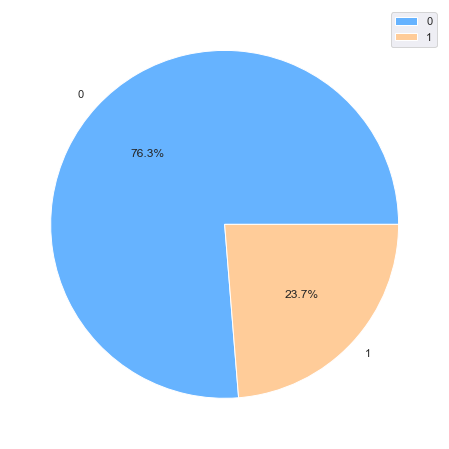

In [3]:
plt.figure(figsize = (12,8))
print(dataset['Is_Lead'].value_counts())
colors = ['#66b3ff','#ffcc99']
plt.pie(dataset['Is_Lead'].value_counts(), labels = ['0','1'], autopct='%.1f%%',colors= colors)
plt.legend()
plt.show()

## 1. Credit_Product去掉空值

In [4]:
dataset = dataset.dropna(axis=0, how='any')

In [5]:
dataset.isna().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [6]:
#取log使其較符合常態分佈

dataset['Avg_Account_Balance'] = np.log(dataset['Avg_Account_Balance'])


# 設定預測目標變數與解釋變數

In [7]:
#設定預測目標變數與解釋變數
dataset_data = dataset.drop('Is_Lead', axis = 1)
dataset_target = dataset['Is_Lead']

#Survived為series，加入[]轉成dataframe
dataset_target2 = dataset[['Is_Lead']]

dataset_data.shape, dataset_target2.shape

((216400, 10), (216400, 1))

In [8]:
#去除ID和Region_Code
features_drop = ['ID', 'Region_Code']
dataset_data = dataset_data.drop(features_drop, axis = 1)

In [9]:
dataset_data.head()

,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Female,73,Other,X3,43,No,13.860193,No
1,Female,30,Salaried,X1,32,No,13.274205,No
2,Female,56,Self_Employed,X3,26,No,14.210464,Yes
3,Male,34,Salaried,X1,19,No,13.061453,No
4,Female,30,Salaried,X1,33,No,13.695360,No


In [10]:
# 取數值＆類別的欄位
data_num_cols = dataset_data._get_numeric_data().columns 
data_cat_cols = dataset_data.columns.difference(data_num_cols)

print("Numeric columns: ", data_num_cols)
print()
print("Categorical columns: ", data_cat_cols)

Numeric columns:  Index(['Age', 'Vintage', 'Avg_Account_Balance'], dtype='object')

Categorical columns:  Index(['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation'], dtype='object')


In [11]:
#區分數值＆類別資料

data_num_data = dataset_data.loc[:, data_num_cols]
data_cat_data = dataset_data.loc[:, data_cat_cols]

print("Shape of num data:", data_num_data.shape)
print("Shape of cat data:", data_cat_data.shape)

Shape of num data: (216400, 3)
Shape of cat data: (216400, 5)


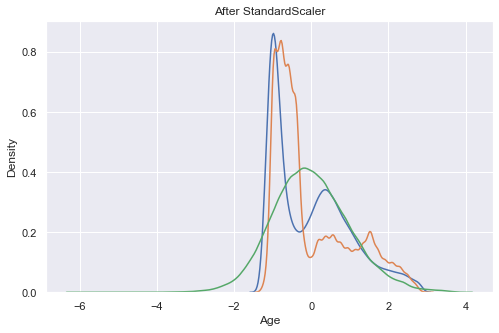

In [12]:
#利用StandardScaler標準化

from sklearn import preprocessing
s_scaler = preprocessing.StandardScaler()

data_num_data_s = s_scaler.fit_transform(data_num_data)

data_num_data_s = pd.DataFrame(data_num_data_s, columns = data_num_cols)

fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After StandardScaler')

sns.kdeplot(data_num_data_s['Age'], ax=ax1)
sns.kdeplot(data_num_data_s['Vintage'], ax=ax1)
sns.kdeplot(data_num_data_s['Avg_Account_Balance'], ax=ax1);

In [13]:
dataset_data.head()

,Gender,Age,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Female,73,Other,X3,43,No,13.860193,No
1,Female,30,Salaried,X1,32,No,13.274205,No
2,Female,56,Self_Employed,X3,26,No,14.210464,Yes
3,Male,34,Salaried,X1,19,No,13.061453,No
4,Female,30,Salaried,X1,33,No,13.695360,No


## 類別轉數值

In [14]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
data_cat_data = data_cat_data.apply(LabelEncoder().fit_transform)

In [15]:
data_num_data_s.reset_index(drop=True, inplace=True)
data_cat_data.reset_index(drop=True, inplace=True)
#df = pd.concat([df1, df2], axis=1)

data_new = pd.concat([data_num_data_s, data_cat_data], axis = 1)

In [16]:
data_new.head()

,Age,Vintage,Avg_Account_Balance,Channel_Code,Credit_Product,Gender,Is_Active,Occupation
0,2.033046,-0.041156,0.225681,2,0,0,0,1
1,-0.862390,-0.393322,-0.718039,0,0,0,0,2
2,0.888339,-0.585412,0.789784,2,0,0,1,3
3,-0.593047,-0.809518,-1.060670,0,0,1,0,2
4,-0.862390,-0.361307,-0.039779,0,0,0,0,2


## 用SMOTE拆分

In [17]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(data_new, dataset_target2)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, plot_roc_curve, auc
from sklearn.metrics import make_scorer


In [20]:
model = XGBClassifier()
model.fit(X_train, y_train)

/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:13:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
predicted = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 90.07%


In [22]:
print(model.feature_importances_)

[0.1743769  0.21743385 0.00675964 0.03541642 0.4209143  0.00673437
 0.06284248 0.07552204]


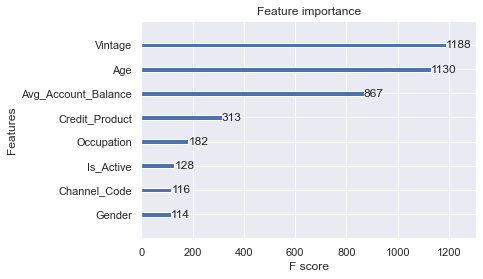

In [24]:
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.datasets import load_iris
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [28]:
thresholds = np.sort(model.feature_importances_)
thresholds


array([0.00673437, 0.00675964, 0.03541642, 0.06284248, 0.07552204,
       0.1743769 , 0.21743385, 0.4209143 ], dtype=float32)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
 
#fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True )
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test,predictions)
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:19:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.007, n=8, Accuracy: 90.07%


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:19:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.007, n=7, Accuracy: 90.00%


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:20:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.035, n=6, Accuracy: 90.11%


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:20:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.063, n=5, Accuracy: 90.06%


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:20:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.076, n=4, Accuracy: 90.05%


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:21:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.174, n=3, Accuracy: 89.59%


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:21:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.217, n=2, Accuracy: 85.86%
[22:21:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Thresh=0.421, n=1, Accuracy: 70.44%


In [29]:
#fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)


selection = SelectFromModel(model, threshold=0.07552204, prefit=True )
select_X_train = selection.transform(X_train)
    

selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
    
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test,predictions)
print(accuracy * 100.0)



/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kainie56560005/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:15:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
90.05393595958216


In [30]:
print(y_pred)



[1 0 0 ... 1 0 1]
